In [34]:
import numpy as np
import pandas as pd
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table
import itertools
from astroquery.simbad import Simbad
from utils import PLOT_PARAMS
PLOT_PARAMS()
from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)


11_19_24


In [2]:
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet

In [3]:
files_p112 = glob.glob('../data/P112_data/*.fits')
files_p113 = glob.glob('../data/P113_data/*.fits')


In [4]:
def get_galah():
    galah =(Table.read('../../lithium/data/GALAH_DR3_main_allstar_v2.fits',format='fits'))#.to_pandas()

    dr2_ids = np.array(galah['dr2_source_id']).astype('str')
    dr3_ids = np.array(galah['dr3_source_id']).astype('str')
    
    galah.remove_column('dr2_source_id')
    galah.remove_column('dr3_source_id')
    galah = galah.to_pandas()

    galah.insert(2, 'dr2_source_id', dr2_ids)
    galah.insert(3, 'dr3_source_id', dr3_ids)
    
    galah['ph_qual_wise']=galah['ph_qual_wise'].str.decode("utf-8")
    return galah
galah=get_galah()

In [142]:
def get_dir(files):
    obj_dir = {}

    counts = []
    for i,file in enumerate(files):
        with fits.open(file) as hdul:
            hdul = fits.open(file)
            header  = hdul[0].header
            #print(header.cards['HIERARCH ESO QC CCF RV ERROR'])
            data    = hdul[1].data
            time    = header['HIERARCH ESO QC BJD']
            name    = header['OBJECT']
            obj     = int(header['HIERARCH ESO OBS NAME'].split('-')[0][2:])
            snr     = header['SNR']
            counts.append(obj)

            grade   = header['OB_GRADE'].replace(" ", "")  
            if grade =='C':
                print('RG',obj,header['OB_GRADE'])
                continue

            ra,dec  = header['RA'], header['DEC']
            obs_T   = header['DATE-OBS'].split('T')[0]
            rv_val  =  header['HIERARCH ESO QC CCF RV']#header['HIERARCH ESO OCS OBJ RV'] #km/s
            rv_err  = header['HIERARCH ESO QC CCF RV ERROR'] #km/s
            sc = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
            rv_corr = rv_val
            err_corr = rv_err

            if obj in obj_dir.keys():
                obj_dir[obj]['rv'].append(rv_corr)
                obj_dir[obj]['time'].append(time)
                obj_dir[obj]['err'].append(err_corr)
                obj_dir[obj]['name'].append(name)
                obj_dir[obj]['grade'].append(grade)
                obj_dir[obj]['snr'].append(snr)

            else:
                obj_dir[obj] = {'rv': [rv_corr], 'time': [time], 'err': [err_corr], 
                                'name': [name], 'grade': [grade], 'snr': [snr]}
          
    targets_to_remove = []
    for k, v in obj_dir.items():
        if len(v['time']) < 3:
            targets_to_remove.append(k)
    for i in range(len(targets_to_remove)):
        del obj_dir[targets_to_remove[i]]
    print(len(obj_dir.keys()))

    myKeys = list(obj_dir.keys())
    myKeys.sort()
    obj_dir = {i: obj_dir[i] for i in myKeys}

    return obj_dir

obj_dir_p112 = get_dir(files_p112)
obj_dir_p113 = get_dir(files_p113)

RG 20 C
RG 13 C
RG 14 C
RG 1 C
10
RG 12 C
RG 6 C
RG 3 C
RG 11 C
RG 22 C
RG 15 C
RG 3 C
RG 8 C
RG 3 C
RG 25 C
RG 8 C
RG 22 C
RG 3 C
RG 7 C
RG 23 C
25


In [147]:
def combine_table(obj_dir):
    new_df = {'RG_id':[], 'galah_id': [], 'obj_name': []}

    for k, v in obj_dir.items():
        if len(v['rv']) < 3: 
            continue
        result_table = Simbad.query_objectids(v['name'][0])
        result_table = np.array(result_table).astype('str')

        for i in result_table:
            if 'GALAH' in i: 
                galah_name = i.split(' ')[-1]

        new_df['RG_id'].append(k)
        new_df['galah_id'].append(int(galah_name))
        new_df['obj_name'].append(v['name'][0])

    new_df = pd.DataFrame(new_df)

    new_df = pd.merge(new_df, galah[['sobject_id', 'vbroad', 'fe_h', 'Li_fe', 'ruwe_dr2']], left_on='galah_id', right_on='sobject_id')
    new_df['Li_val'] = new_df.fe_h+new_df.Li_fe+1.05

    cols = ['RG_id', 'galah_id', 'obj_name', 'Li_val', 'vbroad', 'fe_h','ruwe_dr2']
    new_df = new_df[cols]
    new_df.sort_values(by=['RG_id'],inplace=True)
    
    new_df = new_df.round(2)
    return new_df

df_p112 = combine_table(obj_dir_p112)
df_p113 = combine_table(obj_dir_p113)


In [148]:
p112_galah = pd.merge(galah[['sobject_id','logg','teff']], df_p112,left_on='sobject_id', right_on='galah_id', how='right')
p113_galah = pd.merge(galah[['sobject_id','logg','teff']], df_p113,left_on='sobject_id', right_on='galah_id', how='right')


5

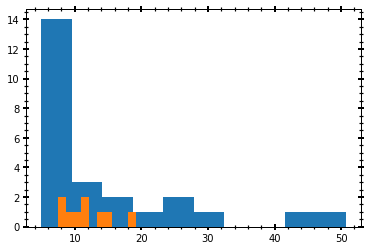

In [151]:
np.min(p113_galah.vbroad), np.max(p113_galah.vbroad)

plt.hist(p113_galah.vbroad)
plt.hist(p112_galah.vbroad)
p113_galah[p113_galah.vbroad <= 10].logg.count()
p113_galah[(p113_galah.vbroad > 10) & (p113_galah.vbroad < 20)].logg.count()
p113_galah[(p113_galah.vbroad >= 20)].logg.count()

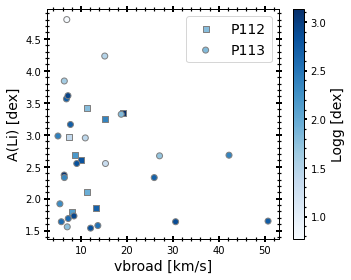

In [152]:
cmap = 'Blues'
vmin = np.min([np.min(p112_galah.logg), np.min(p113_galah.logg)])
vmax = np.max([np.max(p112_galah.logg), np.max(p113_galah.logg)])
plt.figure(figsize=(5,4))
plt.scatter(p112_galah.vbroad, p112_galah.Li_val, marker='s', c=p112_galah.logg, vmin=vmin, vmax=vmax, label='P112', cmap=cmap, ec='grey')
plt.scatter(p113_galah.vbroad, p113_galah.Li_val, marker='o', c=p113_galah.logg, vmin=vmin, vmax=vmax, label='P113', cmap=cmap, ec='grey')
plt.xlabel('vbroad [km/s]')
plt.ylabel('A(Li) [dex]')
plt.colorbar(label='Logg [dex]')
plt.legend()
plt.tight_layout()
#plt.savefig('../plots/ali_vbr.png',bbox_inches='tight',dpi=150)


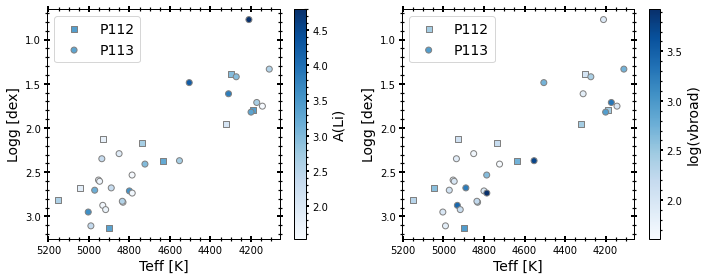

In [153]:
vmin = np.min([np.min(p112_galah.Li_val), np.min(p113_galah.Li_val)])
vmax = np.max([np.max(p112_galah.Li_val), np.max(p113_galah.Li_val)])
cmap = 'Blues'
plt.figure(figsize=(10,4))

ax1=plt.subplot(121)
plt.scatter(p112_galah.teff, p112_galah.logg, marker='s', c=p112_galah.Li_val, vmin=vmin, vmax=vmax, cmap=cmap, ec='grey', label='P112')
plt.scatter(p113_galah.teff, p113_galah.logg, c=p113_galah.Li_val, vmin=vmin, vmax=vmax, cmap=cmap, ec='grey', label= 'P113')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel('Teff [K]')
plt.ylabel('Logg [dex]')
plt.legend()
plt.colorbar(label='A(Li)')

ax2=plt.subplot(122,sharex=ax1, sharey=ax1)
vmin = np.log(np.min([np.min(p112_galah.vbroad), np.min(p113_galah.vbroad)]))
vmax = np.log(np.max([np.max(p112_galah.vbroad), np.max(p113_galah.vbroad)]))

plt.scatter(p112_galah.teff, p112_galah.logg, marker='s', c=np.log(p112_galah.vbroad), vmin=vmin, vmax=vmax, cmap=cmap, ec='grey', label='P112')
plt.scatter(p113_galah.teff, p113_galah.logg, c=np.log(p113_galah.vbroad), vmin=vmin, vmax=vmax, cmap=cmap, ec='grey', label= 'P113')
plt.xlabel('Teff [K]')
plt.ylabel('Logg [dex]')
plt.legend()
plt.colorbar(label='log(vbroad)')
plt.tight_layout()
#plt.savefig('../plots/sample_hrd.png',bbox_inches='tight',dpi=150)


In [154]:
galah_ids_p112 = {
    1: 150107004201104,
    2: 151230003202196,
    4: 161013005401317,
    5: 161104004801189,
    6: 150829004301285,
    7: 160129003601260,
    13: 190212001601338,
    14: 140311007101261,
    23: 170514002101318,
    24: 171208003602294
}

In [155]:
P112_snr = []
P113_snr = []

for k, v in obj_dir_p112.items():
    P112_snr.append(v['snr'])

for k, v in obj_dir_p113.items():
    P113_snr.append(v['snr'])
    
P112_snr = list(itertools.chain(*P112_snr))
P113_snr = list(itertools.chain(*P113_snr))

P112
27, 8-101, N=42
P113
24, 5-125, N=129


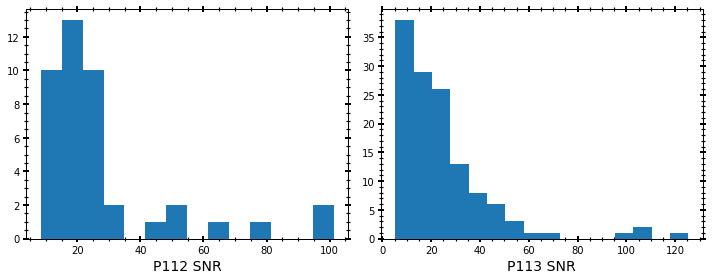

In [156]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hist(P112_snr,bins='auto')
plt.xlabel('P112 SNR')
plt.subplot(122)
plt.hist(P113_snr,bins='auto')
plt.xlabel('P113 SNR')
plt.tight_layout()


print('P112')
print('%i, %i-%i, N=%i'%(np.mean(P112_snr), np.min(P112_snr), np.max(P112_snr), len(P112_snr)))

print('P113')
print('%i, %i-%i, N=%i'%(np.mean(P113_snr), np.min(P113_snr), np.max(P113_snr), len(P113_snr)))

In [157]:
P112_err = []
P113_err = []

for k, v in obj_dir_p112.items():
    P112_err.append(np.array(v['err']))#/np.array(v['rv']))
    #print(np.array(v['err']),np.array(v['rv']))

print('\n')
for k, v in obj_dir_p113.items():
    P113_err.append(np.array(v['err']))#/np.array(v['rv']))
    #print(np.array(v['err']),np.array(v['rv']))
P112_err = list(itertools.chain(*P112_err))
P113_err = list(itertools.chain(*P113_err))

P112
0.022, 0.001-0.066, N=42
P113
0.040, 0.002-0.112, N=129


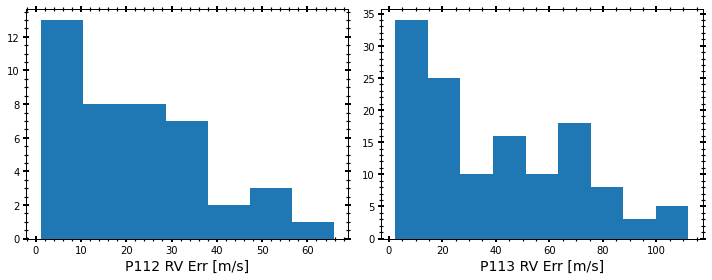

In [158]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hist((P112_err*u.km/u.s).to(u.m/u.s).value,bins='auto')
plt.xlabel('P112 RV Err [m/s]')
plt.subplot(122)
plt.hist((P113_err*u.km/u.s).to(u.m/u.s).value,bins='auto')
plt.xlabel('P113 RV Err [m/s]')
plt.tight_layout()


print('P112')
print('%.3f, %.3f-%.3f, N=%i'%(np.mean(P112_err), np.min(P112_err), np.max(P112_err), len(P112_err)))

print('P113')
print('%.3f, %.3f-%.3f, N=%i'%(np.mean(P113_err), np.min(P113_err), np.max(P113_err), len(P113_err)))

In [159]:

obj_dir_p112_new = obj_dir_p112.copy()
obj_dir_p113_new = obj_dir_p113.copy()
obj_dir_p112_new = {'P112-%i' % k:v for k,v in obj_dir_p112_new.items()}
obj_dir_p113_new = {'P113-%i' % k:v for k,v in obj_dir_p113_new.items()}
obj_dir_both = obj_dir_p112_new.copy()
obj_dir_both.update(obj_dir_p113_new)
# myKeys = list(obj_dir_both.keys())
# myKeys.sort()
# obj_dir_both = {i: obj_dir_both[i] for i in myKeys}

print(len(obj_dir_both.keys()))

35


In [266]:
def make_rv_plot(obj_dir):
    #PLOT_PARAMS(LS=12)

    stats = {'RG_id':[], 'A': []}
    fig = plt.figure(figsize=(12,16))
    for i, (obj, dat) in enumerate(obj_dir.items()):
        if len(dat['time']) > 1:
            #obj = int(obj.split('-')[-1])
            #print(obj,obj_dir[obj])
            ax=plt.subplot(9,4,i+1)
            time    = np.array(obj_dir[obj]['time'])
            rv_vals = np.array(obj_dir[obj]['rv'])
            yerr    = np.array(obj_dir[obj]['err'])
            if obj != 'P113-5':
                mask = (rv_vals >= -100)
                time, rv_vals, yerr = time[mask], rv_vals[mask], yerr[mask]
            
            #print(obj)
            t0   = time[0]
            rv0  = rv_vals[0]
            K0   = (max(rv_vals)-min(rv_vals))/2.

            plt.errorbar(time, rv_vals, 
                         yerr=yerr,
                         fmt='o', color='grey', mec='k', mfc='None', capsize=2)
            #plt.axhline(0, color='k',lw=1,ls='dotted')

            diff = abs(max(rv_vals)-min(rv_vals))
            '''if diff < 0.5:
                ax.set_facecolor('lightcoral')
            elif 0.5 <= diff < 0.7:
                ax.set_facecolor('bisque')
            elif 0.7 <= diff <= 50:
                ax.set_facecolor('lightgreen')
            '''
            #li = new_df[new_df.RG_id==obj]['Li_val'].values[0]
            #vb = new_df[new_df.RG_id==obj]['vbroad'].values[0]
            #li, vb = new_df[new_df.RG_id==obj][['Li_val','vbroad']].values()[0]
            #title = 'RG%s: %.2f \n Li=%.2f vb=%.1f'%(obj,diff,li, vb)
            plt.title(obj)
            stats['RG_id'].append(obj)
            stats['A'].append(diff)
        if i >= 28: 
            plt.xlabel(r'BJD Time [days]',fontsize=10)
        if i % 4 == 0:
            plt.ylabel(r'Radial Velocity [km/s]')
    plt.tight_layout()
#     plt.show()
    
# 1, 2, 4, 5, 7, 13, 24
    #stats = pd.DataFrame(stats)
# make_rv_plot(obj_dir_both)
# plt.savefig('../plots/all_rv_%s.png'%DATE, bbox_inches='tight', dpi=200)

In [274]:
in_113 = 7, 9, 11, 16, 18, 21, 23  # confirmed: 11, 16,18, 23 # not confirmed 9, 19, 21
in_112 = 6, 7, 13, 23


# targets above expectation: 7
targets above exp not confirmed as binary:
	 [19]
# targets above expectation: 4
targets above exp not confirmed as binary:
	 []


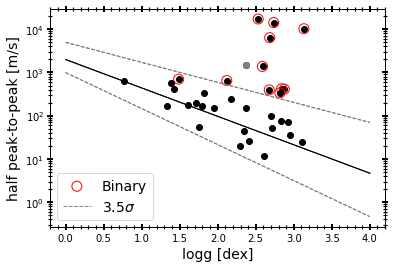

In [275]:
def half_rv(df, obj_dir, program):
    new_df = {'name':[], 'max_rv':[]}
    for k, v in obj_dir.items():
        new_df['name'].append(v['name'][0])
        rv_vals = np.array(v['rv'])
        if k!= 5:
            rv_vals = rv_vals[(rv_vals >= -100)]
        peak_to_peak = max(rv_vals) - min(rv_vals)
        new_df['max_rv'].append((peak_to_peak/2.)*1000)
    new_df = pd.DataFrame(new_df)
    
    merged = pd.merge(new_df, df, left_on='name',right_on='obj_name')
    if program==112:
        mbinary = merged[merged.RG_id.isin(in_112)]
    elif program==113:
        mbinary = merged[merged.RG_id.isin(in_113)]
    plt.scatter(merged.logg, merged.max_rv, c='k')
    plt.scatter(mbinary.logg, mbinary.max_rv, s=100, ec='red',fc='None', label='Binary')
    def semi_log(y1, x2, y2, x, x1=0):
        b = np.log10(y1)
        m = (1./x2)*np.log10(y2/y1)
        y = 10**(m*x+b)
        return y
    
    x = np.linspace(0,4,100)    
    
    y1=semi_log(2000, 3.5, 10, x)
    y2=semi_log(1000, 2.4, 10, x)
    y3=semi_log(5000, 4.0, 70, x)
    plt.plot(x,y1, c='k',ls='solid',lw=1)
    plt.plot(x,y2, c='grey',ls='dashed',label=r'$3.5\sigma$',lw=1)
    plt.plot(x,y3, c='grey',ls='dashed',lw=1)
    #plt.axhline(10, c='grey',ls='dotted', lw=1)
    #plt.axvline(1.3, c='grey',ls='dotted', lw=1)
    plt.yscale('log')
    plt.xlabel('logg [dex]')
    plt.ylabel('half peak-to-peak [m/s]')
    if program == 113:
        plt.legend()
    n = merged[(merged.max_rv>300.) & (merged.logg>2)]
    n = n[~n.RG_id.isin(mbinary.RG_id)]
    plt.scatter(n.logg, n.max_rv, c='grey')
    
    # check how many targets fall above the 3.5 sigma line:
    exp = semi_log(5000, 4.0, 70, merged.logg).to_numpy()
    obs = merged.max_rv.to_numpy()
    N   = len(obs[obs > exp])
    print('# targets above expectation:',N)       
    print('targets above exp not confirmed as binary:')
    print('\t',n.RG_id.to_list())
    return merged
    
    
merged_113 = half_rv(p113_galah,obj_dir_p113,113)
merged_112 = half_rv(p112_galah,obj_dir_p112,112)


# targets above expectation: 7
targets above exp not confirmed as binary:
	 [19]
# targets above expectation: 4
targets above exp not confirmed as binary:
	 []


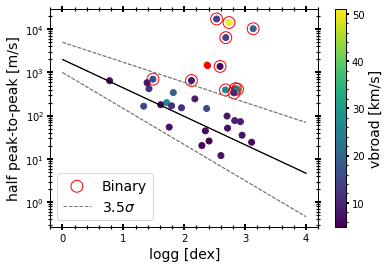

In [276]:
def half_rv(df, obj_dir, program):
    new_df = {'name':[], 'max_rv':[]}
    for k, v in obj_dir.items():
        new_df['name'].append(v['name'][0])
        rv_vals = np.array(v['rv'])
        if k!= 5:
            rv_vals = rv_vals[(rv_vals >= -100)]
        peak_to_peak = max(rv_vals) - min(rv_vals)
        new_df['max_rv'].append((peak_to_peak/2.)*1000)
    new_df = pd.DataFrame(new_df)
    
    merged = pd.merge(new_df, df, left_on='name',right_on='obj_name')
    if program==112:
        mbinary = merged[merged.RG_id.isin(in_112)]
    elif program==113:
        mbinary = merged[merged.RG_id.isin(in_113)]
    vmin, vmax = 5, 51

    plt.scatter(merged.logg, merged.max_rv, c=merged.vbroad, vmin=vmin, vmax=vmax)
    if program==113:
        plt.colorbar(label='vbroad [km/s]')
    plt.scatter(mbinary.logg, mbinary.max_rv, s=140, ec='red',fc='None', label='Binary')
    def semi_log(y1, x2, y2, x, x1=0):
        b = np.log10(y1)
        m = (1./x2)*np.log10(y2/y1)
        y = 10**(m*x+b)
        return y
    
    x = np.linspace(0,4,100)    
    
    y1=semi_log(2000, 3.5, 10, x)
    y2=semi_log(1000, 2.4, 10, x)
    y3=semi_log(5000, 4.0, 70, x)
    plt.plot(x,y1, c='k',ls='solid',lw=1)
    plt.plot(x,y2, c='grey',ls='dashed',label=r'$3.5\sigma$',lw=1)
    plt.plot(x,y3, c='grey',ls='dashed',lw=1)
    #plt.axhline(10, c='grey',ls='dotted', lw=1)
    #plt.axvline(1.3, c='grey',ls='dotted', lw=1)
    plt.yscale('log')
    plt.xlabel('logg [dex]')
    plt.ylabel('half peak-to-peak [m/s]')
    if program == 113:
        plt.legend()
    n = merged[(merged.max_rv>300.) & (merged.logg>2)]
    n = n[~n.RG_id.isin(mbinary.RG_id)]
    #plt.scatter(n.logg, n.max_rv, c='grey')
    
    # check how many targets fall above the 3.5 sigma line:
    exp = semi_log(5000, 4.0, 70, merged.logg).to_numpy()
    obs = merged.max_rv.to_numpy()
    N   = len(obs[obs > exp])
    print('# targets above expectation:',N)       
    print('targets above exp not confirmed as binary:')
    print('\t',n.RG_id.to_list())
    if program==113:
        n = merged[merged.RG_id == 19]
        plt.scatter(n.logg, n.max_rv, color='r')

half_rv(p113_galah,obj_dir_p113,113)
half_rv(p112_galah,obj_dir_p112,112)


1.0794814988486947 4.236917426774277


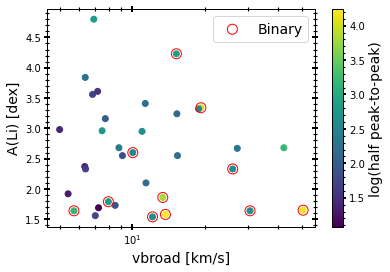

In [277]:
vmin = min([min(np.log10(merged_112.max_rv)), min(np.log10(merged_113.max_rv))])
vmax = max([max(np.log10(merged_112.max_rv)), max(np.log10(merged_113.max_rv))])
print(vmin, vmax)
plt.scatter(merged_112.vbroad, merged_112.Li_val, c=np.log10(merged_112.max_rv), vmin=vmin ,vmax=vmax)
plt.scatter(merged_113.vbroad, merged_113.Li_val, c=np.log10(merged_113.max_rv), vmin=vmin ,vmax=vmax)
plt.colorbar(label='log(half peak-to-peak)')
mbinary = merged_112[merged_112.RG_id.isin(in_112)]

plt.scatter(mbinary.vbroad, mbinary.Li_val, ec='r', s=100, fc='None')
mbinary = merged_113[merged_113.RG_id.isin(in_113)]
plt.scatter(mbinary.vbroad, mbinary.Li_val, ec='r', s=100, fc='None', label='Binary')
plt.legend()
plt.xlabel('vbroad [km/s]')
plt.ylabel('A(Li) [dex]')
plt.xscale('log')

In [278]:
merged_113[(~merged_113.RG_id.isin(in_113)) & (merged_113.vbroad>12)]


,name,max_rv,sobject_id,logg,teff,RG_id,galah_id,obj_name,Li_val,vbroad,fe_h,ruwe_dr2
0,UCAC4 139-176959,343.464512,140806001701013,1.820287,4199.817383,1,140806001701013,UCAC4 139-176959,3.32,18.760000,-0.43,1.01
2,2MASS J16094423-2557437,166.235061,150429004102159,1.333972,4109.809082,3,150429004102159,2MASS J16094423-2557437,2.55,15.340000,-0.79,1.00
5,UCAC4 160-209706,201.330994,170906002101305,1.711411,4171.649414,6,170906002101305,UCAC4 160-209706,2.67,27.100000,-0.45,1.16
18,UCAC2 1639630,1518.724094,170615003401088,2.369927,4552.989258,19,170615003401088,UCAC2 1639630,2.68,42.209999,-0.28,1.13


In [281]:
merged_112[(~merged_112.RG_id.isin(in_112)) & (merged_112.vbroad>12)]


,name,max_rv,sobject_id,logg,teff,RG_id,galah_id,obj_name,Li_val,vbroad,fe_h,ruwe_dr2
7,UCAC4 220-051792,147.081441,140311007101261,2.368252,4635.878906,14,140311007101261,UCAC4 220-051792,3.24,15.26,0.0,1.02


In [280]:
merged_113[merged_113.RG_id==7]

,name,max_rv,sobject_id,logg,teff,RG_id,galah_id,obj_name,Li_val,vbroad,fe_h,ruwe_dr2
6,UCAC4 212-183136,700.182595,160521004801082,1.486652,4504.870605,7,160521004801082,UCAC4 212-183136,4.23,15.18,-1.4,0.99


In [287]:
import pickle

In [293]:
import thejoker as tj
import pymc as pm
import corner
import arviz as az

/opt/miniconda3/lib/python3.9/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


13 [1.01, 1.01, 1.01, 1.01]


<ipython-input-312-d327f2c42230>:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/opt/miniconda3/lib/python3.9/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))




23 [1.01, 1.0, 1.02, 1.03]


<ipython-input-312-d327f2c42230>:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


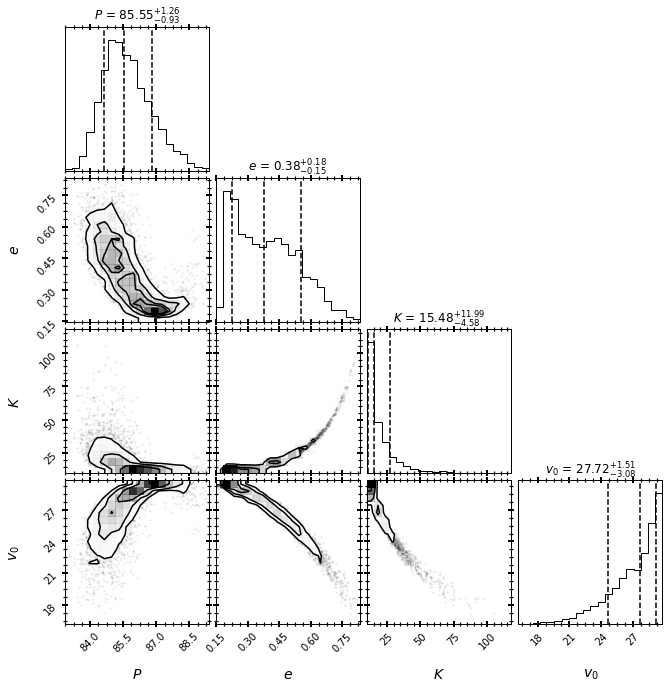

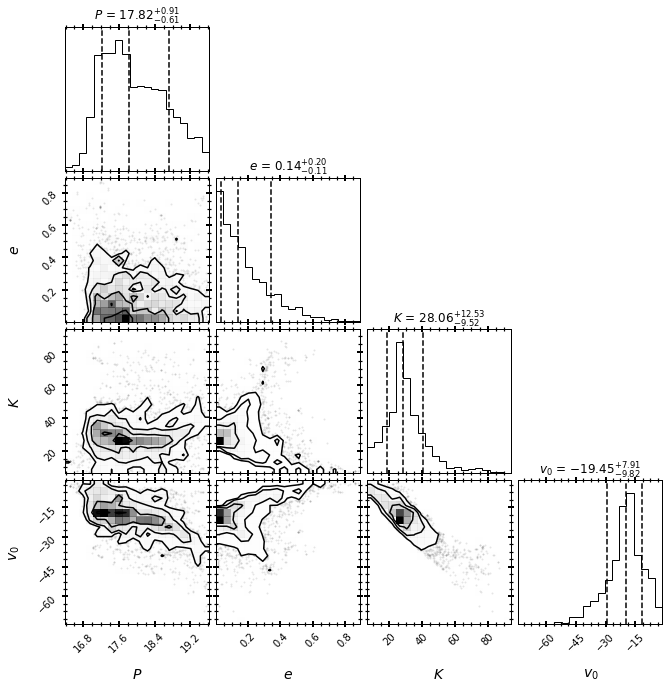

In [312]:
program = 'p112'
DATE    = '11_20_24'
for RG in in_112[-2:]:
    fname1 = '../mcmc/%s/%s_mcmc_%s.pickle'%(program,RG,DATE)
    fname2 = '../mcmc/%s/%s_trace_%s.pickle'%(program,RG,DATE)
    with open(fname1, 'rb') as handle:
        mcmc_samples = pickle.load(handle)
    with open(fname2, 'rb') as handle:
        trace = pickle.load(handle)
    colnames = ['P','e','K','v0']
    summary = az.summary(trace, colnames)
    rhat = summary['r_hat'].to_list() 
    print(RG, rhat)
    fig = corner.corner(mcmc_samples.tbl.to_pandas()[colnames], 
                        labels=[
                            r"$P$", r"$e$", r"$K$",r"$v_0$"],
                        quantiles=[0.16, 0.5, 0.84],
                        show_titles=True,
                        title_kwargs={"fontsize": 12}
                       )
    fig.show()
    print('\n')
    
#     print(mcmc_samples)
#     print(trace)